## **Fig.1: Candidates for first plot**

In [42]:
import sys
sys.path.append("..")
from utils import edgelist_c2c, create_network

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import text, inspect, MetaData

from tqdm import tqdm
import numpy as np
from pathlib import Path
import geopandas as gpd
import pandas as pd
import datetime as dt
from collections import defaultdict, Counter

from dateutil.relativedelta import relativedelta
from scipy.stats import linregress

import nxviz as nv
import networkx as nx
from networkx.algorithms import bipartite
from nxviz import layouts, plots, lines
from nxviz import nodes, edges, annotate, highlights
from nxviz.plots import despine, rescale, respine, aspect_equal

from nxviz.utils import edge_table, node_table
from nxviz import encodings as aes

import matplotlib
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Tahoma"]

basepath = Path.home().joinpath("Documents", "data")
netpath = basepath.joinpath("regulacao", "edgelists")
geopath = basepath.joinpath("shapefilesceqgis")
netpath_ne = basepath.joinpath("regulacao", "edgelists", "nordeste_no_service")

mun_brasil_df = gpd.read_parquet(geopath.joinpath("BR_Municipios_2022", "municipios_brasil_poly_centroid.parquet"))
uf_brasil_df = gpd.read_file(geopath.joinpath("BR_UF_2022", "BR_UF_2022.dbf"))

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [41]:
# -- logarithm scaling of edge fluxes and node sizes.
def logrank(data : pd.Series, max_power_base10 : int, number_of_bins=12):
    logspace = np.logspace(0, max_power_base10, number_of_bins, base=10)
    return data.apply(lambda x: np.argmax(logspace > x)  ) # index of the first true

def summarize_network(G, return_summary=True):
    summary = {}

    # Basic information
    summary['Number of Nodes'] = G.number_of_nodes()
    summary['Number of Edges'] = G.number_of_edges()
    summary['Is Directed'] = G.is_directed()
    summary['Is Bipartite'] = bipartite.is_bipartite(G)

    # Node and edge metadata keys
    if len(G.nodes) > 0:
        summary['Node Metadata Keys'] = list(next(iter(G.nodes(data=True)))[1].keys())
    else:
        summary['Node Metadata Keys'] = []

    if len(G.edges) > 0:
        summary['Edge Metadata Keys'] = list(next(iter(G.edges(data=True)))[2].keys())
    else:
        summary['Edge Metadata Keys'] = []

    # Degree information
    if G.is_directed():
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())
        try:
            summary['Mean In-Degree'] = sum(in_degrees.values()) / len(in_degrees)
        except: pass
        try:
            summary['Mean Out-Degree'] = sum(out_degrees.values()) / len(out_degrees)
        except: pass
    else:
        degrees = dict(G.degree())
        summary['Mean Degree'] = sum(degrees.values()) / len(degrees)

    # Printing summary
    for key, value in summary.items():
        print(f"{key}: {value}")

    if return_summary:
        return summary

## **Geolocation of municipalities**

In [55]:
mun_brasil_df["GEOCOD6"] = mun_brasil_df["CD_MUN"].apply(lambda x: x[:6])
mun_brasil_df['centroid'] = mun_brasil_df.centroid
mun_brasil_df["lat"] = mun_brasil_df['centroid'].y
mun_brasil_df["long"] = mun_brasil_df['centroid'].x
mun_brasil_df.sample(n=4)

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_26460\3846067986.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_brasil_df['centroid'] = mun_brasil_df.centroid
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


,CD_MUN,AREA_KM2,geometry,GEOCOD6,centroid,lat,long
3042,3168051,193.082,"POLYGON ((-41.52395 -19.72099, -41.52433 -19.7...",316805,POINT (-41.61156 -19.73861),-19.738614,-41.611560
2295,3104700,1836.925,"POLYGON ((-41.23562 -18.03045, -41.23576 -18.0...",310470,POINT (-41.15149 -18.16337),-18.163374,-41.151488
3468,3517703,362.183,"POLYGON ((-47.86492 -20.47323, -47.86498 -20.4...",351770,POINT (-47.77525 -20.48258),-20.482583,-47.775247
404,1716505,2019.556,"POLYGON ((-48.15614 -8.98466, -48.15611 -8.984...",171650,POINT (-48.03421 -9.22690),-9.226904,-48.034211


## connection to database

In [3]:
basepath = Path.home().joinpath("Documents", "data")
sih_location = basepath.joinpath("opendatasus")
sih_name = "SIHSUS_NORDESTE_NO_SERVICE.db"

cnes_location = basepath.joinpath("opendatasus", "cnes")
cnes_name = "CNES_NORDESTE.db"

sih_engine_url = f"sqlite:///{sih_location.joinpath(sih_name)}"
sih_engine = create_engine(sih_engine_url)

cnes_engine_url = f"sqlite:///{cnes_location.joinpath(cnes_name)}"
cnes_engine = create_engine(cnes_engine_url)

## **Generate edgelist data - C2C**

In [4]:
output = basepath.joinpath("regulacao", "edgelists", "nordeste_no_service")

In [122]:
selected_year = 2009
periods = [
    (dt.datetime(selected_year, 1, 1), dt.datetime(selected_year, 3, 31)),
    (dt.datetime(selected_year, 4, 1), dt.datetime(selected_year, 6, 30)),
    (dt.datetime(selected_year, 7, 1), dt.datetime(selected_year, 9, 30)),
    (dt.datetime(selected_year, 10, 1), dt.datetime(selected_year, 12, 31)),
]

for interval in tqdm(periods):
    start_date, final_date = interval[0], interval[1]
    start_date_str, final_date_str = start_date.strftime("%Y%m"), final_date.strftime("%Y%m")

    c2c_diag_people = edgelist_c2c(sih_engine, start_date, final_date, diag_level=3, mode="people")
    c2c_diag_money = edgelist_c2c(sih_engine, start_date, final_date, diag_level=3, mode="money")
    c2c_diag_people.to_parquet(output.joinpath("c2c", f"c2c_diag_people_{start_date_str}_{final_date_str}.parquet"))
    c2c_diag_money.to_parquet(output.joinpath("c2c", f"c2c_diag_money_{start_date_str}_{final_date_str}.parquet"))

100%|██████████| 4/4 [14:10<00:00, 212.61s/it]


## **Load the networks**

In [124]:
selected_year = 2009
networks = []

for interval in tqdm(periods):
    start_date, final_date = interval[0], interval[1]
    start_date_str, final_date_str = start_date.strftime("%Y%m"), final_date.strftime("%Y%m")

    edgelist = pd.read_parquet(output.joinpath("c2c", f"c2c_diag_people_{start_date_str}_{final_date_str}.parquet"))
    edgelist = edgelist.reset_index()

    # -- filter fluxes only between northeast states 
    ne_ufs = ["21", "22", "23", "24", "25", "26", "27", "28", "29"]
    edgelist["CD_UF_RES"] = edgelist["MUNIC_RES"].apply(lambda x: x[:2])
    edgelist["CD_UF_MOV"] = edgelist["MUNIC_MOV"].apply(lambda x: x[:2])
    edgelist = edgelist[(edgelist["CD_UF_RES"].isin(ne_ufs)) & (edgelist["CD_UF_MOV"].isin(ne_ufs))]

    net = create_network(edgelist, net_type="c2c")
    networks.append(net)

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
 25%|██▌       | 1/4 [00:13<00:41, 13.70s/it]c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
 50%|█████     | 2/4 [00:25<00:25, 12.61s/it]c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
 75%|███████▌  | 3/4 [00:39<00:13, 13.07s/it]c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Pass

In [123]:
networks[0].number_of_nodes()

1794

In [131]:
code_to_lat = dict(zip(mun_brasil_df["GEOCOD6"], mun_brasil_df["lat"]))
code_to_long = dict(zip(mun_brasil_df["GEOCOD6"], mun_brasil_df["long"]))

# -- logarithm scaling of edge fluxes and node sizes.
def logrank(data : pd.Series, max_power_base10 : int, number_of_bins=12):
    logspace = np.logspace(0, max_power_base10, number_of_bins, base=10)
    return data.apply(lambda x: np.argmax(logspace > x)  ) # index of the first true

def generate_features_for_plot(network, code_to_lat, code_to_long, prop_scale=1.5, threshold=0):
    cur_network = network.copy()
    cur_network.remove_edges_from(nx.selfloop_edges(cur_network))
    # -- remove 'fernando de noronha'
    #cur_network.remove_node('260545')
    pos_for_plot = {}
    for v in cur_network.nodes():
        cur_network.nodes[v]['lat'] = code_to_lat[v]
        cur_network.nodes[v]['long'] = code_to_long[v]
        pos_for_plot.update({v : np.array([cur_network.nodes[v]['long'], cur_network.nodes[v]['lat']])})

    # -- for layout
    # -- in-strength
    in_strength_lst = pd.Series([ elem for elem in list( {node: sum(data['SOMA'] for _, _, data in cur_network.in_edges(node, data=True)) for node in cur_network.nodes()}.values() ) ])
    max_power_base10 = np.ceil(np.log10(np.abs(in_strength_lst.max())))

    # -- node size scaling
    in_strength_logrank = (logrank(in_strength_lst, max_power_base10, number_of_bins=12) + 1)*prop_scale

    # -- edge weights
    weight_edge = pd.Series([ cur_network.edges[u,v]['SOMA'] for u,v in cur_network.edges ])
    max_power_base10_count = np.ceil(np.log10(np.abs(weight_edge.max())))
    weight_edge1 = ( logrank(weight_edge, max_power_base10, number_of_bins=12) + 1)/logrank(weight_edge, max_power_base10, number_of_bins=12).max()
    weight_edge1 = pd.concat([weight_edge, weight_edge1], axis=1).rename({0: 'abs', 1: 'normed'}, axis=1)
    weight_edge1["normed"] = weight_edge1.apply(lambda x: 0 if x["abs"]<=threshold else x["normed"], axis=1)

    return {
        'network': cur_network, 'position_dict': pos_for_plot, 'node_size': in_strength_lst,
        'node_size_log': in_strength_logrank, 'edge_weight': weight_edge1,
    }

feature_dict_0 = generate_features_for_plot(networks[0], code_to_lat, code_to_long, prop_scale=1.5, threshold=3)
feature_dict_1 = generate_features_for_plot(networks[1], code_to_lat, code_to_long, prop_scale=1.5, threshold=3)
feature_dict_2 = generate_features_for_plot(networks[2], code_to_lat, code_to_long, prop_scale=1.5, threshold=3)
feature_dict_3 = generate_features_for_plot(networks[3], code_to_lat, code_to_long, prop_scale=1.5, threshold=3)

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


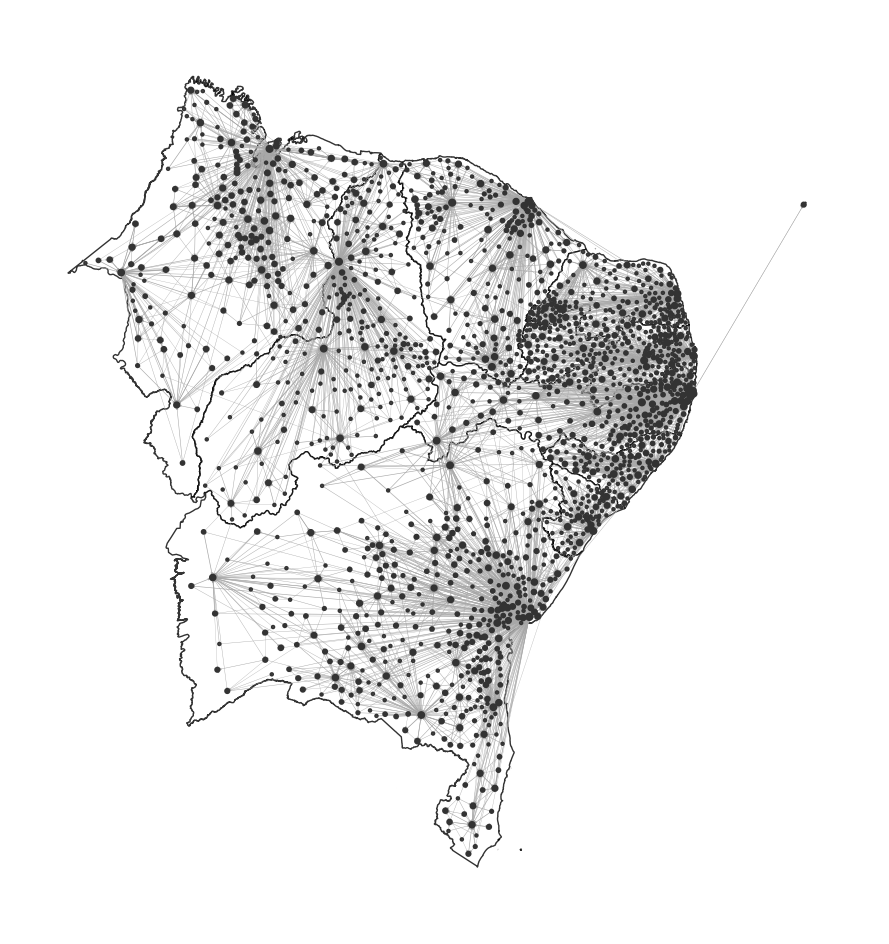

In [118]:
fig, ax = plt.subplots(1, figsize=(12,12))

# -- brazilian northeast map
ne_map = uf_brasil_df[uf_brasil_df["CD_UF"].isin(['21', '22', '23', '24', '25', '26', '27', '28', '29'])].copy()
ne_map.plot(ax=ax, color="#ffffff00", edgecolor="#000000", linewidth=1.0, alpha=0.8)

feature_map = feature_dict_0
cur_network = feature_map['network'].copy()
# -- remove 'fernando de noronha' for plotting

node_position = feature_map['position_dict']
node_size = feature_map['node_size']
node_size_log = feature_map['node_size_log']
edge_weight = feature_map['edge_weight']

nx.draw(cur_network, pos=node_position, ax=ax, arrows=True, arrowsize=3, node_size=node_size_log, node_color="#333333", edge_color="#a7a7a7", width=weight_edge1["normed"]*0.6, alpha=1.0, linewidths=2)

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


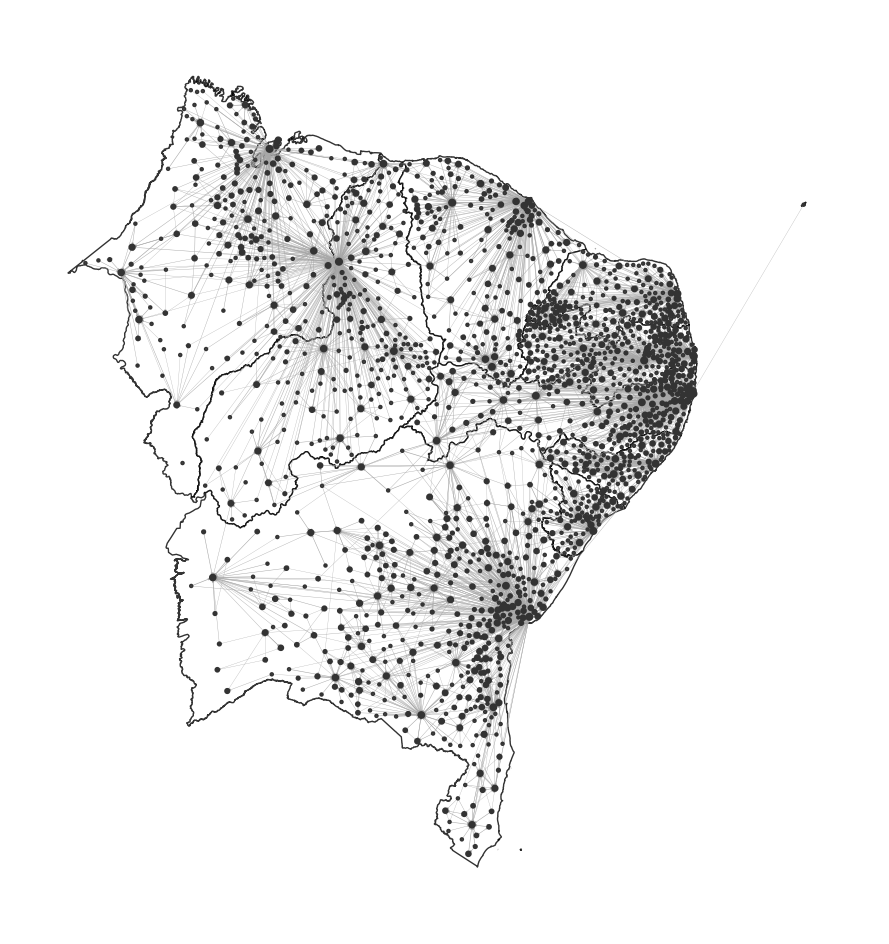

In [132]:
fig, ax = plt.subplots(1, figsize=(12,12))

# -- brazilian northeast map
ne_map = uf_brasil_df[uf_brasil_df["CD_UF"].isin(['21', '22', '23', '24', '25', '26', '27', '28', '29'])].copy()
ne_map.plot(ax=ax, color="#ffffff00", edgecolor="#000000", linewidth=1.0, alpha=0.8)

feature_map = feature_dict_0
cur_network = feature_map['network'].copy()
# -- remove 'fernando de noronha' for plotting

node_position = feature_map['position_dict']
node_size = feature_map['node_size']
node_size_log = feature_map['node_size_log']
edge_weight = feature_map['edge_weight']

nx.draw(cur_network, pos=node_position, ax=ax, arrows=True, arrowsize=3, node_size=node_size_log, node_color="#333333", edge_color="#a7a7a7", width=edge_weight["normed"]*0.6, alpha=1.0, linewidths=2)

In [140]:
ming = edge_weight.groupby("normed")['abs'].min().reset_index().rename({"normed":"group", "abs": "min"}, axis=1)
maxg = edge_weight.groupby("normed")['abs'].max().reset_index().rename({"normed":"group", "abs": "max"}, axis=1)
count = edge_weight.groupby("normed")['abs'].count().reset_index().rename({"normed":"group", "abs": "count"}, axis=1)
ming.merge(maxg).merge(count)

,group,min,max,count
0,0.000000,1.0,3.0,4315
1,0.333333,4.0,8.0,1524
2,0.444444,9.0,23.0,1669
3,0.555556,24.0,65.0,1353
4,0.666667,66.0,186.0,736
5,0.777778,188.0,533.0,115
6,0.888889,589.0,1494.0,17
7,1.000000,1825.0,3536.0,3
8,1.111111,5034.0,5034.0,1


In [143]:
import powerlaw

results = powerlaw.Fit(edge_weight['abs'])
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')

Calculating best minimal value for power law fit
2.900622770243827%
93.0


c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


<Axes: >

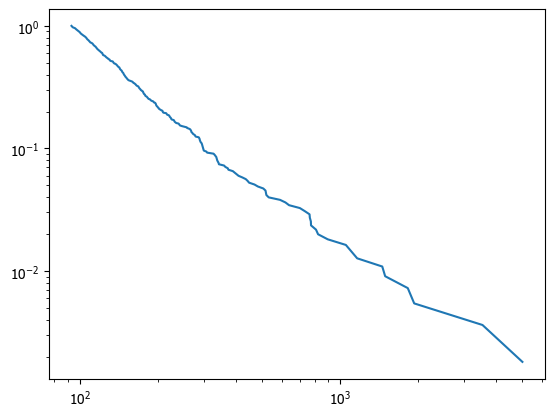

In [145]:
results.plot_ccdf()